In [1]:
%matplotlib inline
import numpy as np
from tqdm import tnrange
import sys
sys.path.append('../')
from qradient.circuit_logic import Qaoa
from qradient.optimization import QaoaOpt
from qradient.optimization_problems import MaxCut
import matplotlib.pyplot as plt

In [2]:
qnum, lnum = 3, 5
edge_num = 3

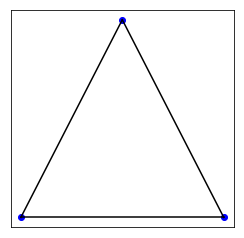

In [3]:
problem = MaxCut(qnum, edge_num)
problem.plot()

In [ ]:
circuit = Qaoa(qnum, problem.to_observable(), lnum)
betas, gammas = np.random.rand(lnum), np.random.rand(lnum)

In [ ]:
# simply run the circuit
circuit.run_expec_val(betas, gammas)

In [ ]:
# evaluate the gradient
e, g = circuit.grad_run(betas, gammas)
print(e)

In [ ]:
# a manual test to make sure the gradient is correct
eps = 10.**-8
dbetas, dgammas = [], []
for i in range(lnum):
    betas[i] += eps
    d2 = circuit.run_expec_val(betas, gammas)
    betas[i] -= 2*eps
    d1 = circuit.run_expec_val(betas, gammas)
    betas[i] += eps
    dbetas.append((d2-d1)*.5/eps)
    gammas[i] += eps
    d2 = circuit.run_expec_val(betas, gammas)
    gammas[i] -= 2*eps
    d1 = circuit.run_expec_val(betas, gammas)
    gammas[i] += eps
    dgammas.append((d2-d1)*.5/eps)
print(np.linalg.norm(np.array(dbetas)-g[:, 0]))
print(np.linalg.norm(np.array(dgammas)-g[:, 1]))

In [ ]:
# sampling the gradient
es, gs = circuit.sample_grad_dense(betas, gammas, shot_num=100, exact_expec_val=False)
print(es)

In [ ]:
# checking that it gives the exact gradient in the limit shot_num=inf
exps = []
grads = []
shot_nums = (10**np.arange(1, 5, .1)).astype('int')
for s in shot_nums:
    print(s, end='\r')
    np.random.seed(0)
    e1, g1 = circuit.sample_grad_dense(betas, gammas, shot_num=s, exact_expec_val=False)
    exps.append(abs(e1 - e))
    grads.append(np.linalg.norm((g1 - g).flatten()))
plt.plot(shot_nums, exps, '.-')
plt.plot(shot_nums, grads, '.-')
plt.loglog()
plt.show()

## Random problems and groundstate energies

In [ ]:
mins = []
for _ in tnrange(100):
    problem = MaxCut(qnum, edge_num)
    circuit = Qaoa(qnum, problem.to_observable(), lnum)
    mins.append(min(circuit.state.gates.classical_ham))

In [ ]:
plt.plot(mins, '.')
plt.show()

## Optimization 

In [ ]:
optimizer = {'name': 'Adam'}
opt = QaoaOpt(circuit, optimizer, betas, gammas)

In [ ]:
opt.reset()
for i in tnrange(200):
    opt.step(shot_num=0)

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.plot(opt.cost_history[:opt.iter])
plt.title('Cost')
plt.subplot(1,3,2)
plt.plot(opt.param_history[:opt.iter,:,0])
plt.title('Betas')
plt.subplot(1,3,3)
plt.plot(opt.param_history[:opt.iter,:,1])
plt.title('Gammas')
plt.show()